In [94]:
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()

# Functions

# Neural Network

In [95]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data
        X_train, X_valid = X[train_indices], X[valid_indices]
        y_train, y_valid = y[train_indices], y[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

#CALL THE MODEL
# def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
#     best_loss = float('inf')
#     patience_counter = 0
#     best_model_path = 'best_model.pth'  # File path for saving the best model

#     for epoch in range(num_epochs):  # number of epochs
#         model.train()
#         train_losses = []
#         for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.squeeze())
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         avg_train_loss = np.mean(train_losses)
#         print(f'Training Loss: {avg_train_loss}')

#         model.eval()
#         valid_losses = []
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels.squeeze())
#                 valid_losses.append(loss.item())

#         avg_valid_loss = np.mean(valid_losses)
#         print(f'Validation Loss: {avg_valid_loss}')

#         # Save the model at each epoch
#         epoch_model_path = f'model_epoch_{epoch + 1}.pth'
#         torch.save(model.state_dict(), epoch_model_path)

#         # Update the best model if validation loss improves
#         if avg_valid_loss < best_loss:
#             best_loss = avg_valid_loss
#             torch.save(model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print('Early stopping triggered')
#                 break

#     # Load the best model
#     model.load_state_dict(torch.load(best_model_path))

#     # Evaluate the best model
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate confusion matrix and classification report
#     conf_matrix = confusion_matrix(all_labels, all_preds)
#     class_report = classification_report(all_labels, all_preds,output_dict=True)
#     print('Confusion Matrix:')
#     print(conf_matrix)
#     print('Classification Report:')
#     print(class_report)
#     return conf_matrix, class_report

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model

    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:  # Use validation data for validation
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use test data for final evaluation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,output_dict=True)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

import os

def save_to_path(df, filename, folder='pybaseball_v3_saved'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    path = os.path.join(folder, f'{filename}.csv')
    
    if os.path.exists(path):
        print(f'File {path} already exists.')
    else:
        df.to_csv(path, index=True)
        print(f'{filename} saved to {path}')

def process_per_game_data(per_game_data, columns_to_keep, train_years):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_Number'] = per_game_data.groupby(['Date', 'HmTm', 'VisTm']).cumcount() + 1
    per_game_data['Game_ID'] = (
        per_game_data['Date'].astype(str) +
        per_game_data['HmTm'] +
        per_game_data['VisTm'] +
        per_game_data['Game_Number'].astype(str)
    )
    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()
    # Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]
    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)
    
    # Truncate rows based on the lowest train year
    lowest_train_year = min(train_years)
    per_game_data = per_game_data[per_game_data.index.str[:4] >= lowest_train_year]
    
    return per_game_data

def process_vegas_odds(paths):
    
    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_Number'] = xlsx_dataframes.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    xlsx_dataframes['Game_ID'] = (
        xlsx_dataframes['date'].astype(str) +
        xlsx_dataframes['home_team'] +
        xlsx_dataframes['visiting_team'] +
        xlsx_dataframes['Game_Number'].astype(str)
    )
   
    xlsx_dataframes.set_index('Game_ID', inplace=True)

    xlsx_dataframes.drop(['Game_Number','date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes

import time
from requests.exceptions import RequestException

def fetch_data_with_retry(fetch_func, data_type, max_retries=5, retry_delay=3):
    retries = 0
    while retries < max_retries:
        try:
            data = fetch_func(True)
            print(f"{data_type} data fetched successfully.")
            return data
        except RequestException as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}. Retrying after {retry_delay} seconds...")
            time.sleep(retry_delay)
            retry_delay *= 2  # Exponential backoff
    print(f"Failed to fetch {data_type} data after {max_retries} attempts.")
    return None

def process_scrambled_odds(df):
    df['Game_Number'] = df.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    df['Game_ID'] = (
        df['date'].astype(str) +
        df['home_team'] +
        df['visiting_team'] +
        df['Game_Number'].astype(str)
    )
   
    df.set_index('Game_ID', inplace=True)  
    
    # Fix: Correct the drop method usage by specifying the column indices correctly
    columns_to_drop = df.columns[[0, 1]]
    print("Dropping columns:", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    return df

def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]

def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
    # Calculate averages
    player_avg = player_data.groupby(player_data.index).mean()

    # Create a dictionary for each stat
    stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

    for column in player_id_columns:
        # Replace the player_IDs in the column with the stats
        for stat, stat_dict in stat_dicts.items():
            per_game_data[column + '_' + stat] = per_game_data[column].map(stat_dict)

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    return per_game_data




def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

def remove_excess_player_columns(player_data,columns_to_remove):
    player_data = player_data.drop(columns=columns_to_remove)
    return player_data

def split_data(per_game_data_reduced, train_year, test_year):
    # Create a mask for the training set
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

    # Split the data into training and testing sets
    X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)

    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']
    
    return X_train, y_train, X_test, y_test

def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method, fill_value=0)
    # Fit and transform all columns
    df[:] = imputer.fit_transform(df)
    return df

class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance

    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data):
        # Ensure the bettor has enough money in the wallet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]
        
        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]
        
        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']
            
            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds
            
            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)
            
            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)

        return self.wallet
    
def combine_odds(per_game_data, vegas_odds, scrambled_odds):
    # Merge vegas_odds and scrambled_odds into per_game_data
    per_game_data = per_game_data.merge(vegas_odds, how='left', left_index=True, right_index=True)
    per_game_data = per_game_data.merge(scrambled_odds, how='left', left_index=True, right_index=True, suffixes=('_vegas', '_scrambled'))

    # Create new columns 'home_odds' and 'visiting_odds' where vegas_odds takes precedence
    per_game_data['home_odds'] = per_game_data['home_open_vegas'].combine_first(per_game_data['home_open_scrambled'])
    per_game_data['visiting_odds'] = per_game_data['visiting_open_vegas'].combine_first(per_game_data['visiting_open_scrambled'])

    # Fill any remaining NaNs with -110
    per_game_data['home_odds'].fillna(-110, inplace=True)
    per_game_data['visiting_odds'].fillna(-110, inplace=True)

    # Drop the original odds columns
    per_game_data.drop(columns=['home_open_vegas', 'visiting_open_vegas', 'home_open_scrambled', 'visiting_open_scrambled'], inplace=True)

    # Reset the index before returning


    # return per_game_data[['home_odds', 'visiting_odds']]
    return per_game_data

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import copy

from sklearn.metrics import accuracy_score

def permutation_importance(model, loader, criterion, metric):
    model.eval()
    original_score = metric(model, loader, criterion)
    importances = []
    for i in range(loader.dataset.X.size(1)):  # Assuming 'X' is the attribute storing your input data
        temp = loader.dataset.X.clone()
        temp[:, i] = torch.randperm(temp.size(0))
        temp_dataset = vector_dataset(temp, loader.dataset.y)  # Assuming 'y' is the attribute storing your labels
        temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
        score = metric(model, temp_loader, criterion)
        importances.append(original_score - score)
    return importances


def automated_feature_selection(model, train_loader, val_loader, test_loader, optimizer, criterion, metric, patience=5, num_epochs=50):
    best_score = 0
    best_model = None
    important_features = list(range(len(train_loader.dataset[0][0])))
    while len(important_features) > 0:
        # Train the model
        conf_matrix, class_report = train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience, num_epochs)
        # Calculate the score
        score = class_report['accuracy']  # Assuming class_report is a dictionary with 'accuracy' key
        # If the score has improved, update the best score and best model
        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(model)
        else:
            # If the score has not improved, add the last removed feature back and break the loop
            important_features.append(last_removed_feature)
            break
        # Calculate the permutation importance
        importances = permutation_importance(model, val_loader.dataset.tensors[0][:, important_features], val_loader.dataset.tensors[1], metric)
        # Remove the least important feature
        last_removed_feature = important_features.pop(np.argmin(importances))
    return best_model, important_features
# usage


# 

# Import Data

In [96]:
test_year = '2023'
train_years = [str(year) for year in range(int(test_year) - 4, int(test_year))]
#Vegas Odds path
vegas_betting_paths='./betting_odds/'
vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

#Scrambled Odds path
scrambled_betting_paths='all_money_lines.csv'
scrambled_odds_full=pd.read_csv(scrambled_betting_paths)

#Per_game_data path
per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



#People Import
chad_v3 = pyb.chadwick_register()

#Vegas Odds Import and process in one
vegas_odds=process_vegas_odds(vegas_paths)

#batter imports full data
batter_data = fetch_data_with_retry(pyb.bwar_bat, 'batter')
#pitcher imports full data
pitcher_data = fetch_data_with_retry(pyb.bwar_pitch, 'pitcher')


#per game data full data
per_game_data_full = pd.read_csv(per_game_path, header=0)



#Drops all columns except for the columns below
columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns','HmTm','VisTm']
per_game_data = process_per_game_data(per_game_data_full, columns_to_keep,train_years)
# per_game_players = add_players_to_games()


                 home_open  visiting_open
Game_ID                                  
20100404BOSNYY1       -114           -106
20100405WASPHI1        170           -200
20100405NYMMIA1       -115           -105
20100405CINSTL1        135           -155
20100405PITLOS1        135           -155
...                    ...            ...
20211027HOUATL1       -115           -105
20211029ATLHOU1       -115           -105
20211030ATLHOU1       -115           -105
20211031ATLHOU1       -105           -115
20211102HOUATL1       -120            100

[28006 rows x 2 columns]
batter data fetched successfully.
pitcher data fetched successfully.


In [97]:

#process scrambled odds
scrambled_odds=process_scrambled_odds(scrambled_odds_full)




#save it to a folder called pybaseball_v3_saved
save_to_path(per_game_data_full, 'per_game_data_full')
save_to_path(per_game_data, 'per_game_data')
save_to_path(batter_data, 'batter_bwar_data')
save_to_path(pitcher_data, 'pitcher_bwar_data')
save_to_path(chad_v3,'chad_v3')
save_to_path(vegas_odds,'vegas_odds')
save_to_path(scrambled_odds,'scrambled_odds')
save_to_path(scrambled_odds_full,'scrambled_odds_full')



pitcher_names = pyb.playerid_reverse_lookup(pitcher_data['player_ID'], key_type='bbref')
batter_names = pyb.playerid_reverse_lookup(batter_data['player_ID'], key_type='bbref')
#For some reason the chad data is missing
batter_data = batter_data[batter_data['player_ID'] != 'stantha01']

# Create a mapping from player_ID to key_retro for pitchers and batters
pitcher_id_to_retro = pitcher_names.set_index('key_bbref')['key_retro'].to_dict()
batter_id_to_retro = batter_names.set_index('key_bbref')['key_retro'].to_dict()

# Replace player_ID with key_retro in pitcher_data and batter_data
pitcher_data['player_ID'] = pitcher_data['player_ID'].map(pitcher_id_to_retro)
batter_data['player_ID'] = batter_data['player_ID'].map(batter_id_to_retro)



batter_data.drop(['name_common','mlb_ID','pitcher','year_ID','salary','PA'], axis=1, inplace=True)
pitcher_data.drop(['name_common','mlb_ID','RpO_replacement','salary','year_ID'], axis=1, inplace=True)
batter_data.drop(batter_data.columns[0],axis=1,inplace=True)
pitcher_data.drop(pitcher_data.columns[0],axis=1,inplace=True)

pitcher_data=remove_columns_with_nan(pitcher_data,40)
batter_data=remove_columns_with_nan(batter_data,40)

batter_data.set_index('player_ID', inplace=True)
pitcher_data.set_index('player_ID', inplace=True)


pitcher_encoded=label_encode(pitcher_data)
batter_encoded=label_encode(batter_data)

# Calculate averages
pitcher_avg = pitcher_data.groupby('player_ID').mean()
batter_avg = batter_data.groupby('player_ID').mean()

# #map player_ids to per_game_data
pitcher_stats_dict = pitcher_avg.to_dict('index')
batter_stats_dict = batter_avg.to_dict('index')


per_game_data_odds = combine_odds(per_game_data, vegas_odds, scrambled_odds)



pitcher_columns = ['HmStPchID', 'VisStPchID']
batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

# Replace the player_IDs with stats
per_game_finished = replace_player_ids_with_stats(per_game_data_odds, pitcher_data, pitcher_columns)
per_game_finished = replace_player_ids_with_stats(per_game_data_odds, batter_data, batter_columns)
per_game_finished = label_encode(per_game_finished)
view_data(per_game_finished)
per_game_finished=Impute(per_game_finished,'mean')


per_game_finished.drop(['home_team','visiting_team','Game_Number'], axis=1, inplace=True)





# remove_columns = ['mlb_ID']
# pitcher_removed=remove_excess_player_columns(pitcher_data,remove_columns)
# batter_removed=remove_excess_player_columns(batter_data,remove_columns)

X_train, y_train, X_test, y_test = split_data(per_game_finished, train_years, test_year)
# Assume X_train and X_test are your input data

# scaler = StandardScaler()

# # Fit on training set only.
# scaler.fit(X_train)

# # Apply transform to both the training set and the test set.
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)



# Split the original training data into new training data and validation data
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val_tensor = torch.from_numpy(X_val.values).float()
y_val_tensor = torch.from_numpy(y_val.values).long()
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)

val_dataset = vector_dataset(X_val_tensor, y_val_tensor)
train_dataset = vector_dataset(X_train_new, y_train_new)
test_dataset = vector_dataset(X_test, y_test)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

num_runs = 3
conf_matrices = []
class_reports = []



# Assuming `vector_dataset` is a class that converts your data into a format suitable for PyTorch


# Calculate the permutation importance of each feature
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)


# Get feature importances
importances = svc.feature_importances_

# Print the feature importance for each column
for feature_name, importance in zip(X_train.columns, importances):
    print(f"{feature_name}: {importance}")

def remove_unimportant_features(importances, threshold=0.06):
    # Get the indices of the features with importance less than the threshold
    unimportant_feature_indices = np.where(importances < threshold)[0]
    # Remove the unimportant features from the dataset
    important_feature_indices = [i for i in range(X_test.shape[1]) if i not in unimportant_feature_indices]
    X_test_new = X_test.iloc[:, important_feature_indices]
    X_train_new = X_train.iloc[:, important_feature_indices]
    X_val_new = X_val.iloc[:, important_feature_indices]

    
    return X_train_new, X_val_new, X_test_new

X_train_new, X_val_new, X_test_new = remove_unimportant_features(importances)

# Create a new model with the updated number of features

# Create new DataLoaders with the updated datasets
train_dataset_new = vector_dataset(X_train_new, y_train_new)
val_dataset_new = vector_dataset(X_val_new, y_val)
test_dataset_new = vector_dataset(X_test_new, y_test)

train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=64, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)



# Now you can train this model with the dropped datasets
for _ in range(num_runs):
    # Reinitialize the model for each run
  
    model = neural_net(X_train_new.shape[1], X_train_new.shape[1]*2, 2, 2, 0.15)
    # model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()

    conf_matrix, class_report = train_and_evaluate_model(model, train_loader_new, val_loader_new, test_loader_new, optimizer, criterion)
    # conf_matrix, class_report = train_and_evaluate_model(model, train_loader,val_loader, test_loader, optimizer, criterion)
    conf_matrices.append(conf_matrix)
    class_reports.append(pd.DataFrame(class_report).transpose())

 #Average the confusion matrices
avg_conf_matrix = sum(conf_matrices) / num_runs

# Average the classification reports
avg_class_report = pd.concat(class_reports).groupby(level=0).mean()

print('Average Confusion Matrix:')
print(avg_conf_matrix)
print('Average Classification Report:')
print(avg_class_report)




ok, bets, skipped = predict_game_outcome(X_test_new.index, X_test_new.values, model, True, 10, 3)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)
for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished)
# Create a new model with the updated number of features


Dropping columns: Index(['date', 'GameId'], dtype='object')
File pybaseball_v3_saved\per_game_data_full.csv already exists.
File pybaseball_v3_saved\per_game_data.csv already exists.
File pybaseball_v3_saved\batter_bwar_data.csv already exists.
File pybaseball_v3_saved\pitcher_bwar_data.csv already exists.
File pybaseball_v3_saved\chad_v3.csv already exists.
File pybaseball_v3_saved\vegas_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds_full.csv already exists.
The column Game_Number has 69.7% NaN values.
The column HmBat9ID_OPS_plus has 0.1% NaN values.
The column VisBat9ID_OPS_plus has 0.1% NaN values.


In [ ]:
import matplotlib.pyplot as plt

def plot_wallet_balance(better):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(better.wallet_history)), better.wallet_history)
    plt.xlabel('Number of Games Bet')
    plt.ylabel('Wallet Balance')
    plt.title('Wallet Balance Over Number of Games Bet')
    plt.grid(True)
    plt.show()

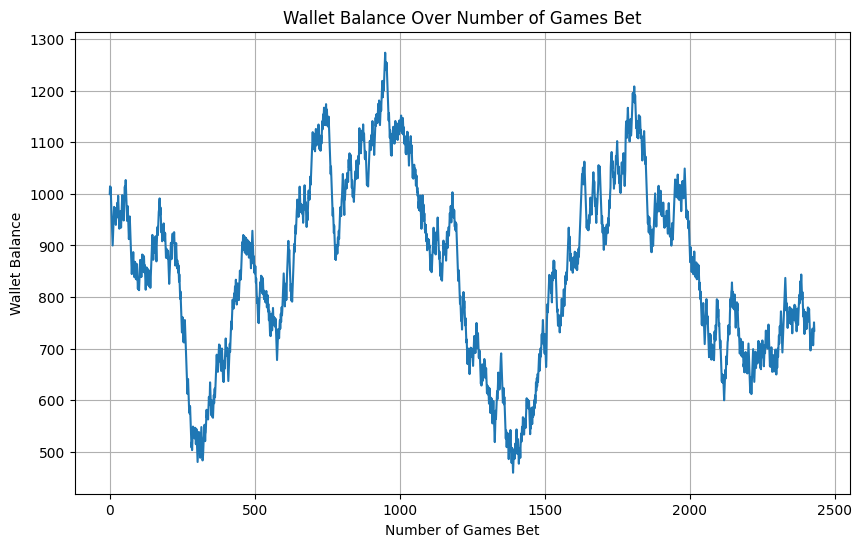

In [ ]:
plot_wallet_balance(better)

In [ ]:
view_data(per_game_finished)

There are no NaN values in the dataset


In [ ]:
duplicates = pitcher_data.index.duplicated()
print(f"There are {duplicates.sum()} duplicate indices in the player_data DataFrame.")


There are 43910 duplicate indices in the player_data DataFrame.


In [ ]:
# Get unique batter and pitcher ids from per_game_data
batter_ids_per_game = per_game_data[batter_columns].values.flatten()
pitcher_ids_per_game = per_game_data[pitcher_columns].values.flatten()

# Check if these ids exist in the batter and pitcher data
batter_ids_exist = batter_data['player_ID'].isin(batter_ids_per_game).any()
pitcher_ids_exist = pitcher_data['player_ID'].isin(pitcher_ids_per_game).any()

print(f"Do any batter ids in per_game_data exist in batter_data? {batter_ids_exist}")
print(f"Do any pitcher ids in per_game_data exist in pitcher_data? {pitcher_ids_exist}")

KeyError: 'player_ID'

In [ ]:
missing_pitcher_ids =  set(pitcher_names['key_bbref']) - set(pitcher_data['player_ID'])
print(f'There are {len(missing_pitcher_ids)} pitcher IDs missing in the pitcher_names dataframe.')
if len(missing_pitcher_ids) > 0:
    print(f'The missing pitcher ID is {list(missing_pitcher_ids)[0]}')

In [ ]:
missing_pitcher_ids = set(batter_data['player_ID']) - set(batter_names['key_bbref'])
print(f'There are {len(missing_pitcher_ids)} pitcher IDs missing in the pitcher_names dataframe.')
if len(missing_pitcher_ids) > 0:
    print(f'The missing pitcher ID is {list(missing_pitcher_ids)[0]}')

In [ ]:
# len(pitcher_data['player_ID'].unique())
len(batter_data['player_ID'].unique())

In [ ]:
# view_data(pitcher_names)
view_data(batter_data)